<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression 
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

## Подготовка

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
data.sort_index(inplace=True)

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data = data.resample('1H').sum()

<AxesSubplot:xlabel='datetime'>

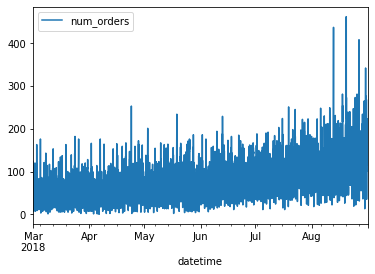

In [6]:
data.plot()

In [7]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<AxesSubplot:>

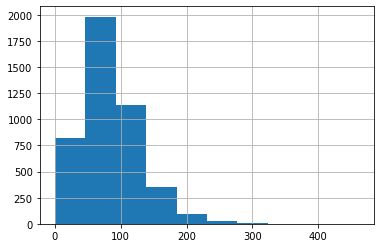

In [8]:
data['num_orders'].hist()

In [9]:
data['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

Данные выгружены. Был произведен ресэмлинг с периодом 1 час.

## Анализ

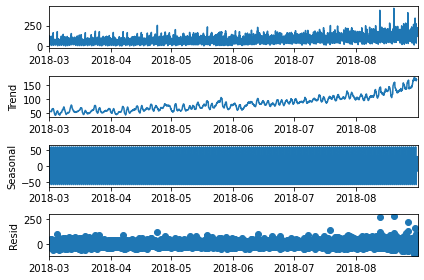

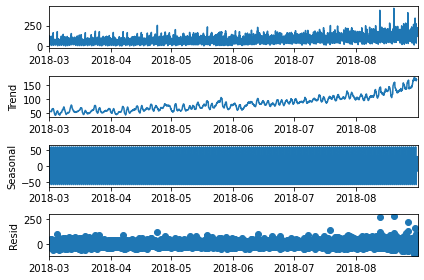

In [10]:
temp = data['2018':'2020']

decomposed = seasonal_decompose(temp)
decomposed.plot()

<AxesSubplot:xlabel='datetime'>

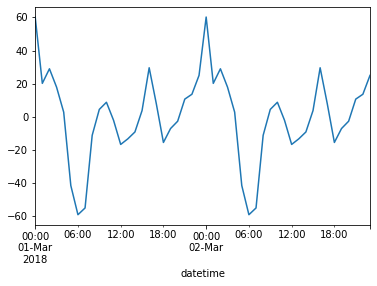

In [11]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot()

Трендом является, то, что количество заказов растёт в течение года.<br>
Сезонностью является, то, что количество заказов имеет период в 1 день, где в 00:00 является пиком, который идёт на спад до 06:00, достигая минимума за день, далее идёт подъём до 09:00, далее функция, то возрастает, то убывает до 18:00, после чего возрастает до 00:00

## Обучение

In [12]:
Y = data['num_orders'].values
result = adfuller(Y)
print('Коэффициент расширенного теста Дики-Фуллера: %f' % result[0])
print('Критические значения: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Коэффициент расширенного теста Дики-Фуллера: -3.068924
Критические значения: 0.028940
	1%: -3.432
	5%: -2.862
	10%: -2.567


Итак, Статистика теста равна 0.028940, и это значение больше всех трех значениями уровней статистической значимости, что означает стационарность.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    temp = data.copy()
    temp['year'] = temp.index.year
    temp['month'] = temp.index.month
    temp['day'] = temp.index.day
    temp['dayofweek'] = temp.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        temp['lag_{}'.format(lag)] = temp['num_orders'].shift(lag)

    temp['rolling_mean'] = temp['num_orders'].shift().rolling(rolling_mean_size).mean()
    return temp

In [30]:
data_up = make_features(data, 31, 1)

train, test = train_test_split(data_up, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(columns='num_orders')
target_train = train['num_orders']
features_test = test.drop(columns='num_orders')
target_test = test['num_orders']

In [15]:
def root_mean_squared_error(Y, prediction):
    return mean_squared_error(Y, prediction)**(0.5)

In [16]:
scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [17]:
cv_time = TimeSeriesSplit(n_splits=5)

In [18]:
#instantiating the model
model = Ridge()

#defining the parameter grid 
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
              'fit_intercept': [True, False],
              'normalize': [True, False],
              'max_iter': [100, 500, 1000]}

#instantiating the GridSearchCV object 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_time, scoring=scorer)

#fitting the model to the data 
grid_search.fit(features_train, target_train)

#printing out the best parameters 
print('Best parameters: {}'.format(grid_search.best_params_))

Best parameters: {'alpha': 0.01, 'fit_intercept': True, 'max_iter': 100, 'normalize': True}


In [19]:
#instantiating the model
model = LinearRegression()

#defining the parameter grid 
param_grid = {'fit_intercept': [True, False],
              'normalize': [True, False],
              'copy_X': [True, False]}

#instantiating the GridSearchCV object 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_time, scoring=scorer)

#fitting the model to the data 
grid_search.fit(features_train, target_train)

#printing out the best parameters 
print('Best parameters: {}'.format(grid_search.best_params_))

Best parameters: {'copy_X': True, 'fit_intercept': True, 'normalize': True}


In [ ]:
#instantiating the model
model = CatBoostRegressor()

#defining the parameter grid 
param_grid = {'depth': [3, 5, 7],
              'learning_rate': [0.01, 0.1, 0.2],
              'iterations': [50, 100, 200]}

#instantiating the GridSearchCV object 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_time, scoring=scorer)

#fitting the model to the data 
grid_search.fit(features_train, target_train)

#printing out the best parameters 
print('Best parameters: {}'.format(grid_search.best_params_))

In [21]:
rid = Ridge(alpha=0.1, fit_intercept=True, max_iter=100, normalize=True)
print('RMSE: ', cross_val_score(rid, features_train, target_train, cv=cv_time, scoring=scorer).mean())

RMSE:  -31.180894704060233


In [28]:
lr = LinearRegression(copy_X=True, fit_intercept=True, normalize=True)
print('RMSE: ', cross_val_score(lr, features_train, target_train, cv=cv_time, scoring=scorer).mean())

RMSE:  -31.149976558786914


In [23]:
cat = CatBoostRegressor(depth=7, iterations=200, learning_rate=0.1, verbose=False)
print('RMSE: ', cross_val_score(cat, features_train, target_train, cv=cv_time, scoring=scorer).mean())

RMSE:  -27.45268261033658


## Тестирование

In [31]:
%%time
cat = CatBoostRegressor(depth=7, iterations=200, learning_rate=0.1)
cat.fit(features_train, target_train)

0:	learn: 37.0307857	total: 15.5ms	remaining: 3.09s
1:	learn: 35.5454732	total: 28.5ms	remaining: 2.82s
2:	learn: 34.1611124	total: 41.6ms	remaining: 2.73s
3:	learn: 32.9304312	total: 55.4ms	remaining: 2.71s
4:	learn: 31.8863871	total: 67.6ms	remaining: 2.64s
5:	learn: 30.8774339	total: 80.6ms	remaining: 2.61s
6:	learn: 30.0219600	total: 94.1ms	remaining: 2.6s
7:	learn: 29.3160917	total: 109ms	remaining: 2.61s
8:	learn: 28.6393652	total: 124ms	remaining: 2.63s
9:	learn: 28.0163227	total: 141ms	remaining: 2.68s
10:	learn: 27.5150699	total: 159ms	remaining: 2.74s
11:	learn: 27.1059739	total: 173ms	remaining: 2.7s
12:	learn: 26.6980250	total: 186ms	remaining: 2.67s
13:	learn: 26.3708980	total: 199ms	remaining: 2.64s
14:	learn: 25.9975756	total: 211ms	remaining: 2.61s
15:	learn: 25.6512317	total: 231ms	remaining: 2.65s
16:	learn: 25.3649003	total: 247ms	remaining: 2.65s
17:	learn: 25.1507495	total: 259ms	remaining: 2.62s
18:	learn: 24.9172576	total: 272ms	remaining: 2.59s
19:	learn: 24.676

In [32]:
%%time
print('RMSE: ', root_mean_squared_error(target_train, cat.predict(features_train)))

RMSE:  14.68149295021938
CPU times: user 3.36 ms, sys: 3.95 ms, total: 7.31 ms
Wall time: 4.51 ms


In [33]:
print('RMSE: ', root_mean_squared_error(target_test, cat.predict(features_test)))

RMSE:  40.88750697946893


In [ ]:
pred = cat.predict(features_test)
plt.figure(figsize=(15,10))
plt.plot(target_test.index, target_test)
plt.plot(target_test.index, pred)
plt.show()

## Вывод

В ходы выполнения проекта был изучен временной ряд, его сезонность и тренд.<br>
Трендом является, то, что количество заказов растёт в течение года.<br>
Сезонностью является, то, что количество заказов имеет период в 1 день, где в 00:00 является пиком, который идёт на спад до 06:00, достигая минимума за день, далее идёт подъём до 09:00, далее функция, то возрастает, то убывает до 18:00, после чего возрастает до 00:00<br>
Был обучено несколько моделей, среди которых, лучшей показал себя catboostRegressor(depth=7, iterations=200, learning_rate=0.1).<br>
Время обучения: 3.38 sec<br>
Время предсказания: 4.51 ms<br>
RMSE: 40.88

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48